In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm
from scipy.optimize import fsolve

In [2]:
def expected_acceptance_length(alpha, draft):
    if alpha == 1.0:
        return draft + 1
    else:
        return (1. - alpha ** (draft + 1)) / (1. - alpha)

In [3]:
def getTTFT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    ttft=[]
    rps=[]
    for i in range(len(data)):
        ttft.append(data[i]['time_to_first_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    ttft, rps=np.array(ttft), np.array(rps)
    indx=np.argsort(rps)
    ttft = ttft[indx]
    rps = rps[indx]
    ttft = ttft[:-3]
    rps = rps[:-3]
    return rps, ttft

def getITL(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    for i in range(len(data)):
        itl.append(data[i]['inter_token_latency_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]
    # itl = itl[:-3]
    # rps = rps[:-3]

    return rps, itl

def getRequestLatency(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    lat=[]
    rps=[]

    for i in range(len(data)):
        lat.append(data[i]['request_latency']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    lat, rps=np.array(lat), np.array(rps)
    indx=np.argsort(rps)
    lat = lat[indx]
    rps = rps[indx]
    lat = lat[:-3]
    rps = rps[:-3]
    return  rps, lat

def getTPOT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    tpot=[]
    rps=[]
    for i in range(len(data)):
        tpot.append(data[i]['time_per_output_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    tpot, rps=np.array(tpot), np.array(rps)
    indx=np.argsort(rps)
    tpot = tpot[indx]
    rps = rps[indx]
    tpot = tpot[:-3]
    rps = rps[:-3]

    return  rps, tpot

In [4]:
def fit_ITL_from_RPS(path, label=None, debug=False):
    baseline_rps, baseline_itl = getITL(path)
    # sort the baseline_itl indices
    indx = np.argsort(baseline_itl)
    # remove the top 5 entries for both baseline_rps and baseline_itl
    # but do not change the order otherwise
    # indx = indx[:-2]
    idnx = np.sort(indx)
    if debug:
        print(idnx)
    baseline_rps = baseline_rps[idnx]
    baseline_itl = baseline_itl[idnx]
    def model(x, c1, c2):
        return c1 / (1 - c2 * x)
    mask = baseline_itl != 0
    A = np.vstack([np.ones_like(baseline_rps[mask]), baseline_rps[mask]]).T
    z = 1.0 / baseline_itl[mask]
    a, b = np.linalg.lstsq(A, z, rcond=None)[0]   # z ≈ a + b x
    c1_0 = 1.0 / a
    c2_0 = -b / a
    popt, pcov = curve_fit(model, baseline_rps, baseline_itl, p0=[c1_0, c2_0], maxfev=10000)
    # plt plot the data and fit and return the fit parameters
    if debug:
        plt.scatter(baseline_rps, baseline_itl, label='Measured ITL', color='blue')
        plt.xlabel("RPS")
        plt.ylabel("ITL")
        if label is not None:
            plt.title(f"Modeled vs Measured ITL, {label}")
        else:
            plt.title("Modeled vs Measured ITL")
        plt.plot(baseline_rps, model(baseline_rps, *popt), label='Modeled ITL', color='red')
        plt.legend()

        # Add the popt parameters to the plot in the form of the formula
        plt.text(0.05, 0.95, f'ITL = {popt[0]:.2f} / (1 - {popt[1]:.2f} * RPS)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                color='black')
        
        plt.show()
    return popt

In [5]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]

In [6]:
DATA_DIR = "/proving-grounds/machine/linghao/speculators/throughput-reduced"

In [7]:
c1_ns = []
c2_ns = []
for model_size in tqdm(model_sizes):

    # c1 = np.empty((len(alphas), len(drafts)))
    # c1[:] = np.nan
    # c2 = np.empty((len(alphas), len(drafts)))
    # c2[:] = np.nan

    # for i, alpha in enumerate(alphas):
    #     for j, draft in enumerate(drafts):
    #         path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
    #         fit = fit_ITL_from_RPS(path, f"Alpha: {alpha}, Draft: {draft}")
    #         c1[i, j] = fit[0]
    #         c2[i, j] = fit[1]

    path = f"{DATA_DIR}/output_Qwen3-{model_size}_NS_prompt-512_output-128_concurrency-128_reduced.json"
    fit = fit_ITL_from_RPS(path, f"Model Size: {model_size}")
    c1 = fit[0]
    c2 = fit[1]

    c1_ns.append(c1)
    c2_ns.append(c2)

100%|██████████| 6/6 [00:00<00:00, 17.33it/s]


In [8]:
c1_sd = []
c2_sd = []
for model_size in tqdm(model_sizes):

    c1 = np.empty((len(alphas), len(drafts)))
    c1[:] = np.nan
    c2 = np.empty((len(alphas), len(drafts)))
    c2[:] = np.nan

    for i, alpha in enumerate(alphas):
        for j, draft in enumerate(drafts):
            path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
            fit = fit_ITL_from_RPS(path, f"Alpha: {alpha}, Draft: {draft}")
            c1[i, j] = fit[0]
            c2[i, j] = fit[1]

    c1_sd.append(c1)
    c2_sd.append(c2)

100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


In [9]:
def speedup(c1_ns, c2_ns, c1_sd, c2_sd, rps):
    c1_r = c1_sd / c1_ns
    c2_r = c2_sd / c2_ns
    r = c2_ns * rps
    speedup = (1 / c1_r) * (1 + (1 - c2_r) * r / (1 - r))
    return speedup

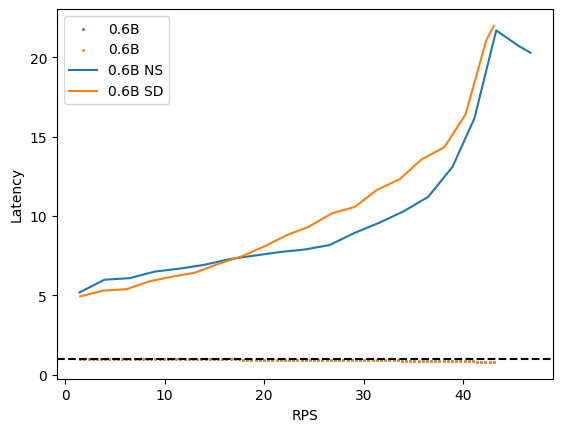

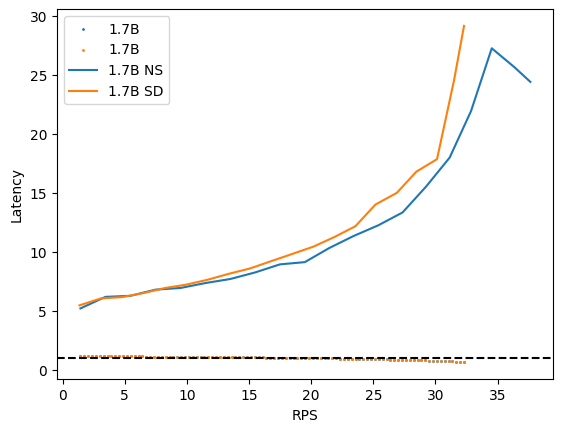

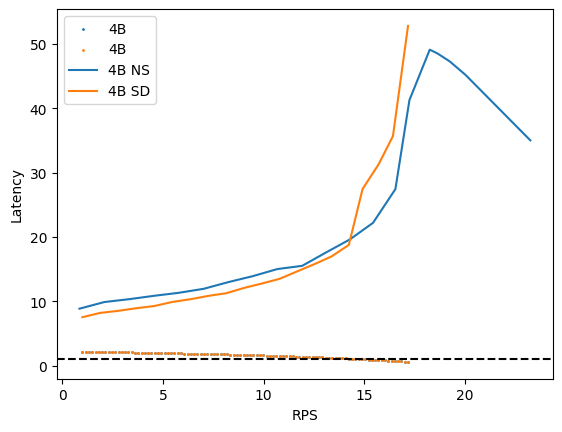

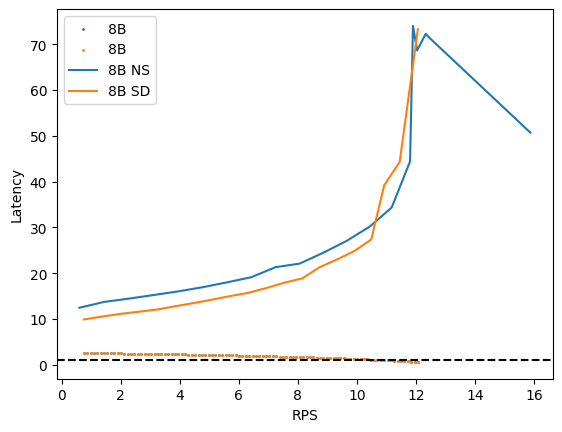

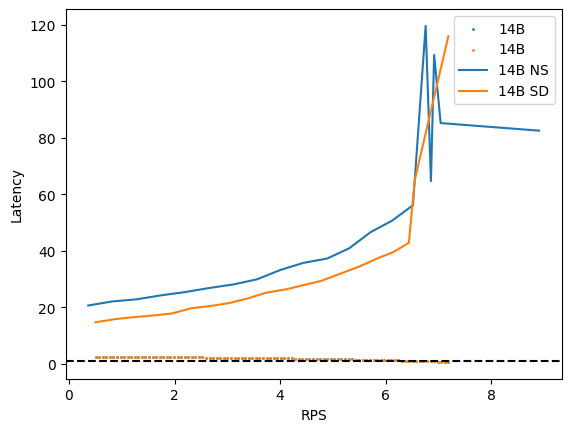

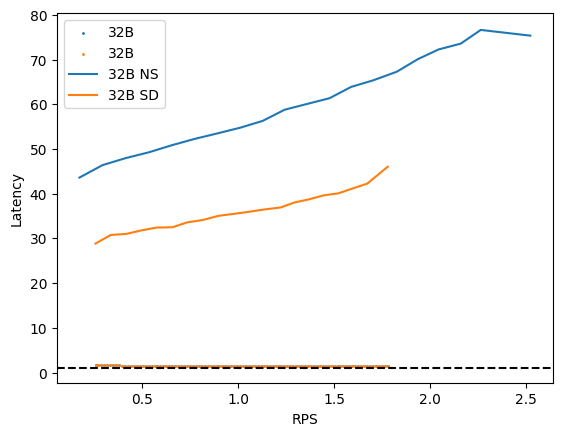

In [12]:
for i, model_size in enumerate(model_sizes):
    alpha = 0.5

    draft = 2
    path_ns = f"{DATA_DIR}/output_Qwen3-{model_size}_NS_prompt-512_output-128_concurrency-128_reduced.json"
    path_sd = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
    rps_ns, lat_ns = getITL(path_ns)
    rps_sd, lat_sd = getITL(path_sd)
    max_rps = min(max(rps_ns), max(rps_sd))
    min_rps = max(min(rps_ns), min(rps_sd))
    curr_c1_ns = c1_ns[i]
    curr_c2_ns = c2_ns[i]
    curr_c1_sd = c1_sd[i][alphas.index(alpha), drafts.index(draft)]
    curr_c2_sd = c2_sd[i][alphas.index(alpha), drafts.index(draft)]
    # plot 100 points between min_rps and max_rps
    rps = np.linspace(min_rps, max_rps, 100)
    model_lat_ns = 1 / (curr_c1_ns / (1 - curr_c2_ns * rps))
    model_lat_sd = 1 / (curr_c1_sd / (1 - curr_c2_sd * rps))
    model_speedup = model_lat_sd / model_lat_ns
    model_speedup_2 = speedup(curr_c1_ns, curr_c2_ns, curr_c1_sd, curr_c2_sd, rps)
    plt.scatter(rps, model_speedup, label=f'{model_size}', s = 1)
    plt.scatter(rps, model_speedup_2, label=f'{model_size}', s = 1)
    plt.plot(rps_ns, lat_ns, label=f'{model_size} NS')
    plt.plot(rps_sd, lat_sd, label=f'{model_size} SD')
    # mak a horizontal line at y = 1
    plt.axhline(y=1, color='black', linestyle='--')
    plt.legend()
    plt.xlabel("RPS")
    plt.ylabel("Latency")
    
    plt.show()
    


In [ ]:
for model_size in tqdm(model_sizes):
    path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
    fit = fit_ITL_from_RPS(path, f"Alpha: {alpha}, Draft: {draft}")

In [5]:
def fit_ITL_from_RPS(rps, lat, Et, k, label=None, debug=False):
    def model(x, b1 , b2, c1, c2, d1, d2, f1, f2):
        return (b1 + b2*k + (c1 + c2*k)/Et) / (1 - (d1 + d2*k + (f1 + f2*k)/Et) * x)
    def fit_model(x, b1, b2, c1, c2, d1, d2, f1, f2):
        rps, lat = x
        return model(rps, b1, b2, c1, c2, d1, d2, f1, f2) / lat
    A = np.vstack([np.ones_like(rps)/lat, k/lat, np.ones_like(rps)/Et/lat, k/Et/lat, rps, rps*k, rps/Et, rps*k/Et]).T
    z = np.ones_like(rps)
    b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0 = np.linalg.lstsq(A, z, rcond=None)[0]   # z ≈ a + b x
    
    # Set bounds to ensure all parameters are non-negative
    # Lower bounds: all parameters >= 0
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0]
    # Upper bounds: no upper limit (use np.inf)
    upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
    bounds = (lower_bounds, upper_bounds)
    
    #popt, pcov = curve_fit(model, baseline_rps, baseline_itl, p0=[c1_0, c2_0], maxfev=10000)
    popt, pcov = curve_fit(fit_model, (rps, lat), np.ones_like(rps), 
                          p0=[b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0], 
                          bounds=bounds, maxfev=10000)
    #popt = [b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    #popt = [c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    # plt plot the data and fit and return the fit parameters
    if debug:
        plt.scatter(rps, lat, label='Request Latency', color='blue')
        plt.xlabel("RPS")
        plt.ylabel("Latency")
        if label is not None:
            plt.title(f"Modeled vs Measured Latency, {label}")
        else:
            plt.title("Modeled vs Measured Latency")
        plt.plot(rps, model(rps, *popt), label='Modeled Latency', color='red')
        plt.legend()

        # Add the popt parameters to the plot in the form of the formula
        plt.text(0.05, 0.95, f'ITL = {popt[0]:.2f} / (1 - {popt[1]:.2f} * RPS)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                color='black')
        
        plt.show()
    return popt

In [6]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]

In [7]:
DATA_DIR = "/home/linghao/speculators/research/scaling/throughput_data"

In [8]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]

alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]

prefill_decode_combinations = [
    (1024, 1024),
    (256, 1024),
    (256, 128),
    (512, 128),
    (512, 256),
    (768, 128),
    (1024, 128),
]

DATA_DIR = "/proving-grounds/machine/linghao/speculators/throughput-reduced/"

In [9]:
# model_sizes = ["4B"]
# alphas = [0.8]
# drafts = [5]





all_b1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_b2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_c1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_c2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_d1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_d2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_f1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_f2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))


all_b1[:] = np.nan
all_b2[:] = np.nan
all_c1[:] = np.nan
all_c2[:] = np.nan
all_d1[:] = np.nan
all_d2[:] = np.nan
all_f1[:] = np.nan
all_f2[:] = np.nan
for i, model_size in tqdm(enumerate(model_sizes), total=len(model_sizes)):
    for j, alpha in enumerate(alphas):
        for k, draft in enumerate(drafts):
            for l, (prefill, decode) in enumerate(prefill_decode_combinations):
                try:
                    path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-{prefill}_output-{decode}_concurrency-128_reduced.json"
                    rps_, lat_ = getRequestLatency(path)
                    Et_ = expected_acceptance_length(alpha, draft)
                    Et_ = np.ones_like(rps_) * Et_
                    k_ = np.ones_like(rps_) * draft
                    fit = fit_ITL_from_RPS(rps_, lat_, Et_, k_, f"Alpha: {alpha}, Draft: {draft}, Prefill: {prefill}, Decode: {decode}", debug=False)
                    all_b1[i, j, k, l] = fit[0]
                    all_b2[i, j, k, l] = fit[1]
                    all_c1[i, j, k, l] = fit[2]
                    all_c2[i, j, k, l] = fit[3]
                    all_d1[i, j, k, l] = fit[4]
                    all_d2[i, j, k, l] = fit[5]
                    all_f1[i, j, k, l] = fit[6]
                    all_f2[i, j, k, l] = fit[7]
                except Exception as e:
                    print(f"Error fitting ITL for {path}: {e}")
                    all_b1[i, j, k, l] = np.nan
                    all_b2[i, j, k, l] = np.nan
                    all_c1[i, j, k, l] = np.nan
                    all_c2[i, j, k, l] = np.nan
                    all_d1[i, j, k, l] = np.nan
                    all_d2[i, j, k, l] = np.nan
                    all_f1[i, j, k, l] = np.nan
                    all_f2[i, j, k, l] = np.nan

 50%|█████     | 3/6 [00:42<00:40, 13.58s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-6_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-6_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-8_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-8_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/s

 67%|██████▋   | 4/6 [00:57<00:28, 14.36s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-1.00_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-1.00_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-1.00_draft-10_prompt-256_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-1.00_draft-10_prompt-256_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-0.50_draft-1_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao

 83%|████████▎ | 5/6 [01:12<00:14, 14.54s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-1.00_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-1.00_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-1.00_draft-10_prompt-256_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-1.00_draft-10_prompt-256_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-0.50_draft-1_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/lin

100%|██████████| 6/6 [01:26<00:00, 14.37s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-10_prompt-256_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-10_prompt-256_output-1024_concurrency-128_reduced.json'


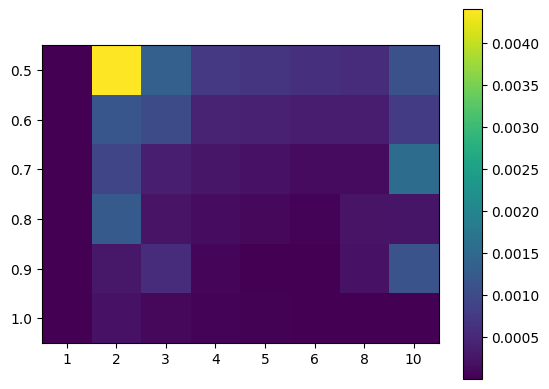

In [10]:
data = all_f2[0, :, :, 2]
cmap = plt.cm.viridis.copy()
cmap.set_bad('red')

plt.imshow(data, cmap=cmap)
plt.colorbar()

# make x axis the drafts
plt.xticks(range(len(drafts)), drafts)
plt.yticks(range(len(alphas)), alphas)

plt.show()
